In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Flatten
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import keras
import codecs
import os

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('posts.csv', names=['Author', 'Text'], sep=',', header=None)
data.head()

,Author,Text
0,22211,"Надо жить у моря, Мама.\n\nAdMe.ru публикует р..."
1,22211,Памятка трейдера.\n\nВыражения и термины приме...
2,22211,"Руслан Проводников или ""Сибирский Рокки"", как ..."
3,61454,"""Выбирай платья на лето"", ""готовься к лету вме..."
4,61454,"""Спят ли мамы?""- я не знала. На такой вопрос о..."


### Подсчет количества слов в корпусе

In [3]:
data['CountWords'] = data['Text'].map(lambda x: len(x.split()))
print('Количество статей в корпусе:', len(data))
data.head()

Количество статей в корпусе: 98442


,Author,Text,CountWords
0,22211,"Надо жить у моря, Мама.\n\nAdMe.ru публикует р...",745
1,22211,Памятка трейдера.\n\nВыражения и термины приме...,482
2,22211,"Руслан Проводников или ""Сибирский Рокки"", как ...",275
3,61454,"""Выбирай платья на лето"", ""готовься к лету вме...",61
4,61454,"""Спят ли мамы?""- я не знала. На такой вопрос о...",180


### Количество статей у каждого пользователя

In [4]:
num_classes = 100
skip_person = 30

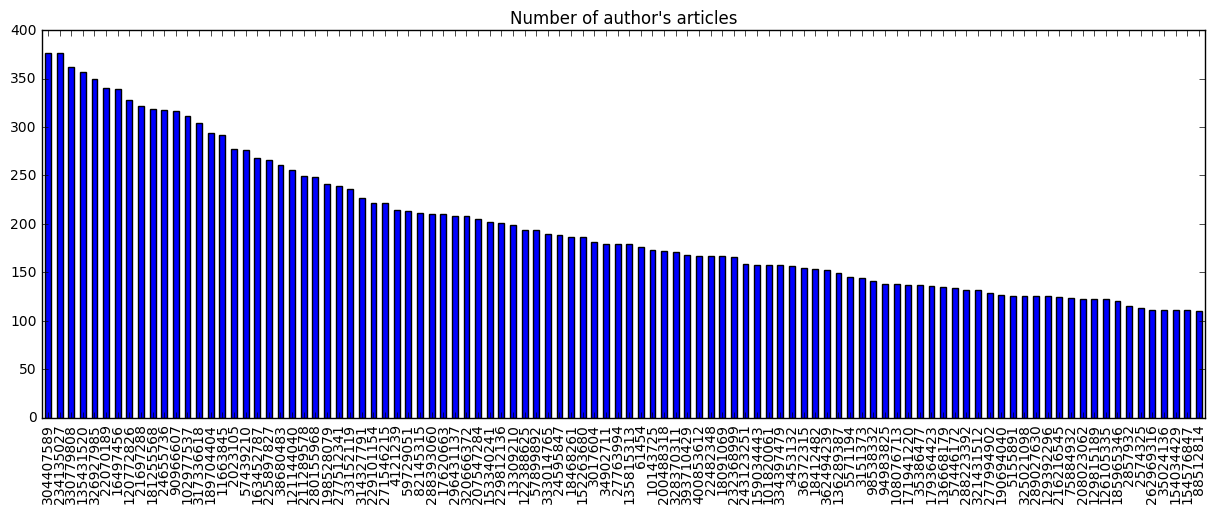

In [5]:
author_count_news = data.Author.value_counts()[skip_person:skip_person + num_classes]
author_count_news.plot(kind='bar', figsize=(15, 5), title="Number of author's articles");

### Подготовка данных

In [6]:
temp_data = pd.DataFrame()
names_author = author_count_news.index.values

for author in names_author:
    temp_data = temp_data.append(data[data.Author == author])

data = temp_data
print('Количество статей после удаления:', len(data))

Количество статей после удаления: 19769


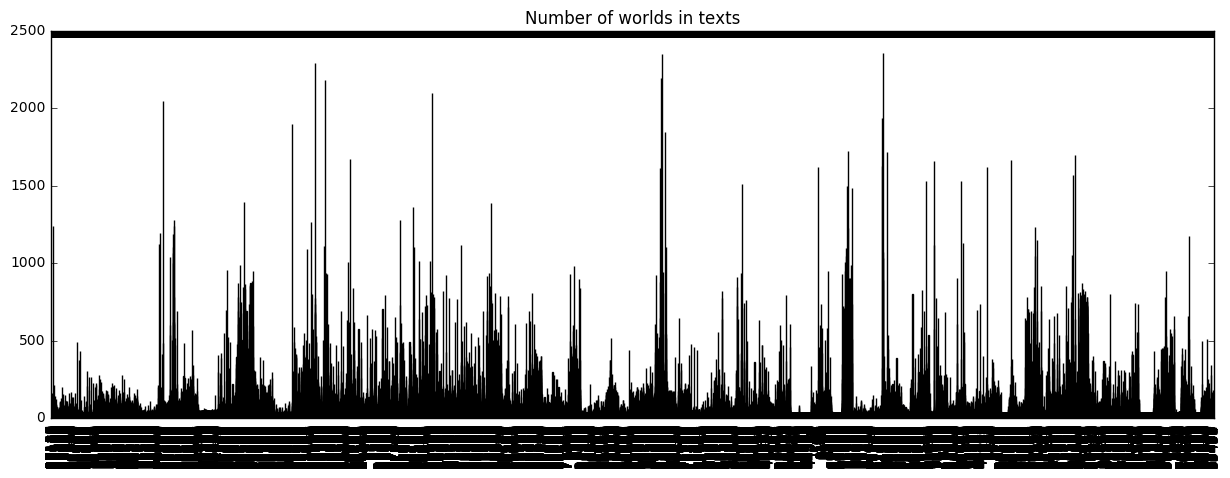

In [7]:
data.CountWords.plot(kind='bar', figsize=(15, 5), title="Number of worlds in texts");

In [8]:
def remove_stopwords(data):
    from nltk.corpus import stopwords
    stop = stopwords.words('russian')
    data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
    print('Stop words have been deleted')

In [9]:
def get_lemmatization_corpus(data):
    import pymorphy2
    morph = pymorphy2.MorphAnalyzer()
    data['TextLem'] = data['Text'].map(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))
    print('The lemmatization completed')

In [10]:
names = data.Author.value_counts().index.values

lableEnc = LabelEncoder()
lableEnc.fit(names.ravel()) 
lables = lableEnc.transform(names).reshape((num_classes, 1))

oneHotEnc = OneHotEncoder()
oneHotEnc.fit(lables)

for author in names:
    val = lableEnc.transform([author])[0]
    data.Author.replace(to_replace=author, value=val, inplace=True)

data.head()

,Author,Text,CountWords
87134,86,"- А вот, помню, у нас в детском садике тоже па...",42
87135,86,"- А вот, помню, у нас в детском садике тоже па...",42
87136,86,"- Алло! Папа, заберёшь меня?\n- Нет.\n- Ну-у-у...",41
87137,86,"- Дети, давайте знакомиться. Расскажите, напри...",33
87138,86,"- Доктор, вы бы не могли мне дать такую таблет...",39


In [11]:
# Перемешать набор данных и удалить index столбец
data = data.sample(frac=1).reset_index(drop=True)

### Токенизация текста

In [12]:
def get_texts_to_matrix(texts, max_features = 0):
    tokenizer = Tokenizer(split=" ", lower=True)
    if max_features != 0:
        tokenizer = Tokenizer(split=" ", lower=True, num_words=max_features)
    
    tokenizer.fit_on_texts(texts)
    matrix_tfidf = tokenizer.texts_to_matrix(texts=texts, mode='tfidf')
    print('Количество текстов:', matrix_tfidf.shape[0])
    print('Количество токенов:', matrix_tfidf.shape[1])
    return matrix_tfidf

In [13]:
def get_texts_to_sequences(text):
    # создаем единый словарь (слово -> число) для преобразования
    tokenizer = Tokenizer(split=" ", lower=True)
    tokenizer.fit_on_texts(text)
    # Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
    text_sequences = tokenizer.texts_to_sequences(text)
    print('В словаре {} слов'.format(len(tokenizer.word_index)))
    return text_sequences

In [14]:
def get_texts_to_gramm_sequences(texts, count_gramm = 3):
    gramms = {}
    counter_gramm = 0
    result = []
    temp_vector = []
    
    for text in texts:
        for i in range(len(text) - count_gramm - 1):
            gramm = text[i : i + count_gramm]
            if gramms.get(gramm) == None:
                gramms[gramm] = counter_gramm
                counter_gramm += 1
            temp_vector.append(gramms[gramm])
        result.append(temp_vector)
        temp_vector = []
        
    print('Количество грамм в корпусе:', len(gramms))
    #count_gramm = [len(x) for x in text_threegramm]
    #num = np.array(count_gramm)
    #num.mean()
    return result

In [15]:
#X = get_texts_to_matrix(data['Text'])
#X = get_texts_to_gramm_sequences(data['Text'])
X = get_texts_to_sequences(data['Text'])

В словаре 182451 слов


### Разбиваем выборку на тестовую и тренировочную

In [16]:
def get_X_y_for_traning(X, y, num_words):
    #tokenizer = Tokenizer(num_words=num_words)
    #X = tokenizer.sequences_to_matrix(X_train, mode='binary')
    X = keras.preprocessing.sequence.pad_sequences(X, maxlen=num_words) 
    y = keras.utils.to_categorical(y, num_classes)
    print('Размерность X:', X.shape) 
    print('Размерность y:', y.shape)
    return X, y

In [17]:
# Максимальное количество слов в самом длинном тексте
num_words = 1000
X_full, y_full = get_X_y_for_traning(X, data.Author, num_words)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=0)

print('Testing set size:', len(X_test))
print('Training set size:', len(X_train))

Размерность X: (19769, 1000)
Размерность y: (19769, 100)
Testing set size: 3954
Training set size: 15815


### Создание модели нейронной сети

In [18]:
def get_lstm_model():
    max_features = 100000
    model = Sequential()
    # Слой для векторного представления слов
    model.add(Embedding(max_features, 500))
    model.add(SpatialDropout1D(0.3))
    # Слой долго-краткосрочной памяти
    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3)) 
    # Полносвязный слой
    model.add(Dense(num_classes, activation="sigmoid"))
    # Копмилируем модель
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def get_conv_model(input_length):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=input_length))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def get_conv_lstm_model(input_length):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=input_length))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)) 
    #model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
model = get_conv_model(input_length = num_words)
model.summary()

BATCH_SIZE = 64
EPOCHS = 9

history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=1, 
                    validation_split=0.1, 
                    callbacks=[EarlyStopping(monitor='val_loss')])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 300)         6000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1000, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 998, 512)          461312    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
Total params: 6,512,612
Trainable params: 6,512,612
Non-trainable params: 0
_________________________________________________________________
Train on 14233 samples, validate on 1582 samples
Epoch 1/9
14233/14233 [==============================] - 39s - loss: 5.1880 - acc: 

In [20]:
print('Точность модели составляет: {}'.format(model.evaluate(X_test, y_test, batch_size=32, verbose=2)[1] * 100))

Точность модели составляет: 0.8851795649974709


dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


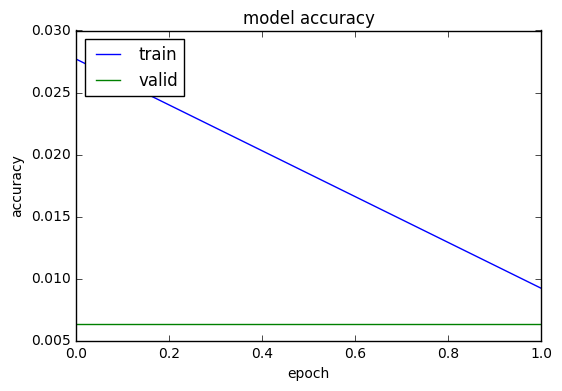

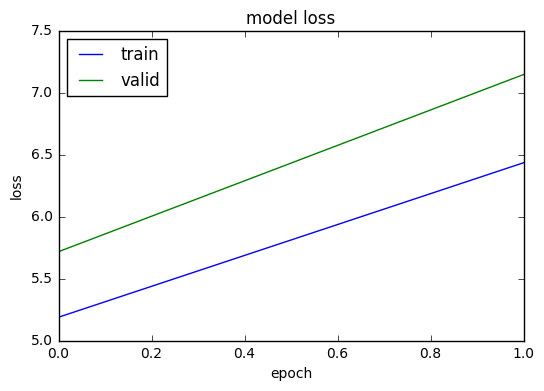

In [21]:
from matplotlib import pyplot as plt
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();